In [1]:
# imports
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.sys.path.append(os.path.abspath("../.."))

import tensorflow as tf

import pandas as pd
import numpy as np
import h5py

from matplotlib import pyplot as plt

from project.notebooks_utils import visuals

from IPython.display import display

import project.download_content as content

from project.utils import data
from project.model.loss import BBOX_REF

from keras.preprocessing import image

from project.utils.data_bbox_match_hdf5 import load_ohc

from project.model.ssd_model_300_xception import ssd_model_300_xception
from project.model.ssd_model_300_resnet import ssd_model_300_resnet
from project.model.ssd_model_300_vgg import ssd_model_300_vgg
from project.model.loss import SSDloss

from project.utils.train_test.data_bbox_match_hdf5 import load_model
from project.utils.category_encoder import CategoryEncoder

from project.utils import data_augmentation as da
from project.model.iou import iou

# one hot encoding
ohc = load_model()

modelpath = os.path.join(os.path.abspath(content.DATAPATH), 'MODEL')

val_files = [os.path.join(modelpath, f'39_classes_300x300_cross_val_{i}.h5')
             for i in range(8)]

test_files = [os.path.join(modelpath, f'39_classes_300x300_test_{i}.h5')
              for i in range(8)]

METAPATH = os.path.join(content.DATAPATH, 'METADATA')




Using TensorFlow backend.


#### Count images in train set

In [2]:
# loading OHC to validate classes
ohc = load_ohc()
ohc.get_feature_names()[232]

'x0_hamburger'

### Loading one image

{0.0, 1.0}

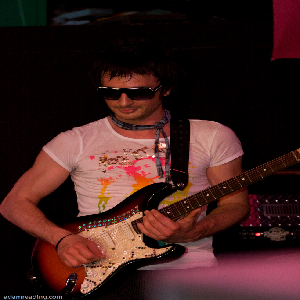

In [3]:
# loading one example image from train data
with h5py.File(os.path.join(METAPATH, 'train_data_650.h5'), 'r') as f:
    batches = f['batches']
    train_X, train_y = f[batches[21][0]][:], f[batches[21][1]][:]

sample = 1

# getting a specific image from the batch
img = train_X[sample]

# getting it target
target = train_y[sample]

# metadata about the image
# id, raw_path = info[sample]

# with h5py.File(val_files[3], 'r') as f:
#     bboxes = f[bboxes_ref][id][:]

# validate that target has at least one bboxes matched
# (containing 1 and 0 in the first columns (no-class))
display(set(target[:, 0]))

image.array_to_img(img)
# bboxes

In [4]:
bboxes_orig = []
for i, *x in enumerate(target[:, 1:]):
    if sum(*x) > 0:
        print(i, np.argmax(target[i][:-4]))
        bboxes_orig.append(target[i][-4:].tolist())
bboxes_orig

8728 261
8729 380
8730 380
8731 261


[[0.41943359375, 0.6884765625, 0.8388671875, 0.62158203125],
 [0.422607421875, 0.609375, 0.84521484375, 0.7783203125],
 [0.422607421875, 0.609375, 0.84521484375, 0.7783203125],
 [0.41943359375, 0.6884765625, 0.8388671875, 0.62158203125]]

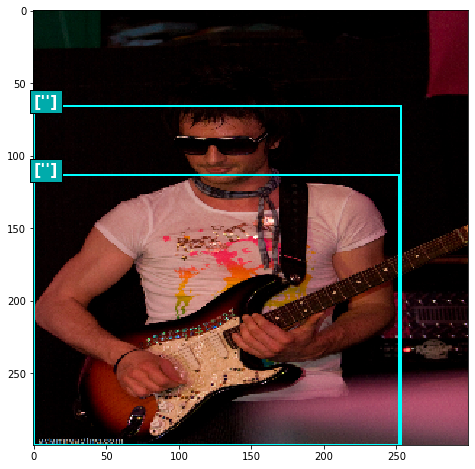

In [5]:
img_jpg = image.array_to_img(img)

plt.figure(figsize=(12,8))
plt.imshow(img_jpg)

visuals.draw_many_bboxes(img_jpg, np.array(bboxes_orig));

## model

The model has 7 layers to draw the bounding_boxes, they were called as `number_bbs`

in each layer there are some types of bouding boxes, specified as follow:

|         | number of regions | size of filter in pixels | ratios w/h          | number of bounding boxes |
|---------|-------------------|--------------------------|---------------------|--------------------------|
| 1st_bbs | 5776              | 24px/24px                | [1, 1/2, 2]         | 17328                    |
| 2nd_bbs | 1369              | 48px/48px                | [1, 1/2, 2]         | 4107                     |
| 3rd_bbs | 289               | 98px/98px                | [1, 1/2, 1/3, 2, 3] | 1445                     |
| 4th_bbs | 49                | 208px/208px              | [1, 1/2, 1/3, 2, 3] | 245                      |
| 5th_bbs | 25                | 267px/267px              | [1, 1/2, 1/3, 2, 3] | 125                      |
| 6th_bbs | 9                 | 374px/374px              | [1, 1/2, 1/3, 2, 3] | 45                       |
| 7th_bbs | 1                 | 623px/624px              | [1, 1/2, 1/3, 2, 3] | 5                        |

In [6]:
os.path.abspath(content.DATAPATH) + '/resnet-weights300.h5'

'/home/bruno/projetos/capstone-udacity-mle/project/data/resnet-weights300.h5'

In [7]:
model = ssd_model_300_resnet(inference=True)
# model = ssd_model_300_resnet(inference=False)

display(model.summary())


model.load_weights('/home/bruno/projetos/backup-capstone/restnet-650/resnet-weights300.h5')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

None

## Training

(200, 6)

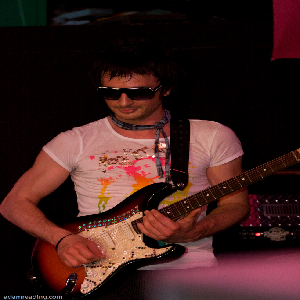

In [8]:
# loading one example image from train data
with h5py.File(os.path.join(METAPATH, 'train_data_650.h5'), 'r') as f:
    batches = f['batches']
    train_X, train_y = f[batches[21][0]][:], f[batches[2][1]][:]

sample = 1

img = train_X[sample]
target = train_y[sample]

norm_img = da.normalize(img)

pred_batch = model.predict(np.expand_dims(img, axis=0))
pred = pred_batch[0]

display(pred.shape)

display(image.array_to_img(norm_img))

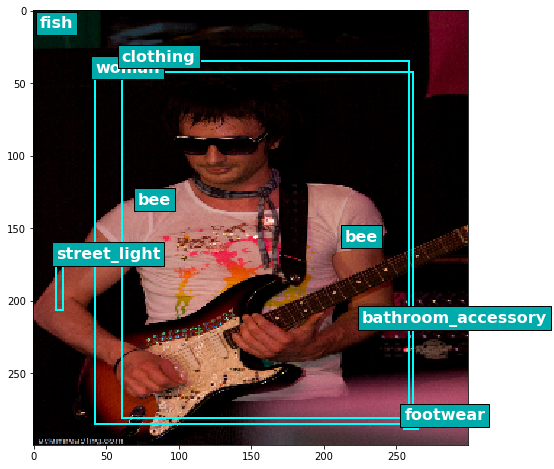

In [9]:
img_jpg = image.array_to_img(img)

plt.figure(figsize=(12,8))
plt.imshow(img_jpg)

topk = 10
visuals.draw_many_bboxes(img_jpg, pred[:, -4:],
                         label=[ohc.get_feature_names()[int(i - 1)][3:]
                                for i in pred[:topk, 0]])